In [1]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import copy

In [2]:
# Define Class to store and load the student dataset eficient

class StudentDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# Define parameters:

# percentage of raining data
train_perc = 0.8
# batch size
batch_size = 8

In [4]:
# Define a instance of the Student Dataset based on the exsisting student data 
dataset = StudentDataset("Data/labels.csv", "Data/3_Data_OneSet_Cropped")

# Get length of dataset
data_len = len(dataset)

# calculate length of train and test set
train_len = int(data_len * train_perc)
test_len = data_len-train_len

# Define train and test date
train_data, test_data = torch.utils.data.random_split(dataset, [train_len,test_len])

# Create the dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Add the datasets,dataloaders and data_lens to a dictionary each
image_datasets = {"train": train_data, "val": test_data}
dataloaders = {"train": train_loader, "val": test_loader}
dataset_sizes = {"train": train_len, "val": test_len}

# Get the classnames from the capturing folder
label_names = list()
for name in os.listdir("Data/1_Data_Capture"):
    if not os.path.isdir(name):
        label_names.append(name)
label_names.sort()

# Get labels from classnames
class_names = list(range(len(label_names)))

print(class_names)
#print(class_labels)

[0, 1]


In [5]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


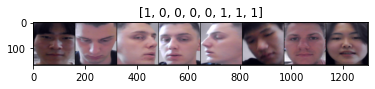

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.float().to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
resnet = models.resnet18(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(class_names))

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_resnet = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

In [9]:
resnet = train_model(resnet, criterion, optimizer_resnet, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4303 Acc: 0.7925
val Loss: 0.1254 Acc: 0.9500

Epoch 1/24
----------
train Loss: 0.0965 Acc: 0.9623
val Loss: 0.0222 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.0470 Acc: 0.9874
val Loss: 0.0118 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.0859 Acc: 0.9748
val Loss: 0.0313 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.0192 Acc: 1.0000
val Loss: 0.0074 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.0316 Acc: 1.0000
val Loss: 0.0063 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1321 Acc: 0.9560
val Loss: 0.0329 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0263 Acc: 1.0000
val Loss: 0.0034 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0234 Acc: 1.0000
val Loss: 0.0025 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0287 Acc: 0.9937
val Loss: 0.0017 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0125 Acc: 1.0000
val Loss: 0.0015 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0072 Acc: 1.0000
val Loss: 0.0015 Acc: 1.0000

Ep

In [10]:
# Safe model (by saving the weights)
model_path = "Model_Weights/resnet.pt"
print("Saving model to: '" + model_path + "'");
torch.save(resnet.state_dict(), model_path)

Saving model to: 'Model_Weights/resnet.pt'
